# Finding a good route to work

## Scenario

You live in a city where the streets have deteriorated due to poor management. Every day, you travel from home to work, navigating through streets in varying conditions. Your goal is to find the best route that minimizes the amount of time spent commuting. Streets have the following conditions, each affecting travel time differently:

    Street in good condition: Time = 1 unit.
    Dirt road: Time = 2 units.
    Street with cracks and water leaks: Time = 4 units.
    Potholes: Time = 5 units.
    Road closures: Impossible to pass (encoded as -1).
    Buildings: Impossible to pass (encoded as -10)

Implement a solution to find the optimal route from home (5,3) to work's parking (16, 26). Assume every street is two-way.

## Important
### Dont forget to install the dependencies to see the correct implementation

In [ ]:
%pip install numpy
%pip install matplotlib
%pip install seaborn

## Algorithm
Since we are working with a non-dynamic model (pre-established map, conditions and only 1 agent), we can use pathfinding algorithm that establishes a path before the simulation runs. In this case the most obvius answer would be to implement weighted A*, because we have different pre established values in this problem.

## Libraries

### NetworkX
NetworkX is a library used for graphs, it handles nodes, edges and more things graph related, its used for ease of implementation of the A* Algorithm and for ease of transforming the grid into a graph.

In our implementation its specifically used as:
Streets → Graph nodes
Connections → Graph edges
Road conditions → Edge weights
Buildings/closures → Removed nodes
A* -> Finds optimal path considering weights

### Matplotlib
Used for visualizing the map and the route to follow. Facilitates understaing the result

### Socket
Socket library is used to send data from a csv with the path to unity so that we can visualize the movemnt of the "car" that is currently represented as a cube

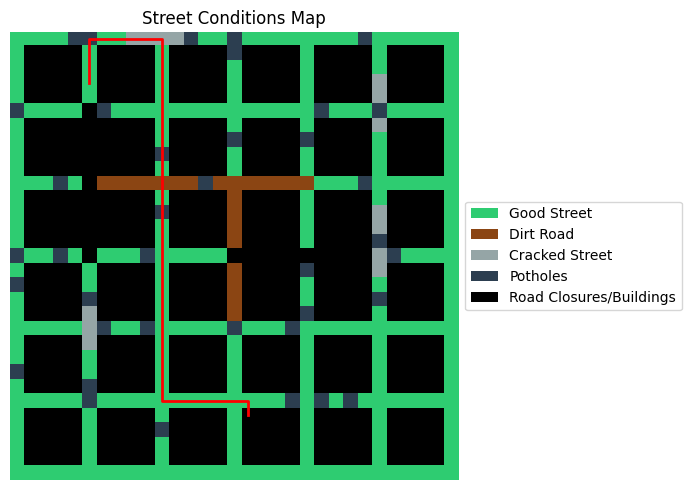

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import ListedColormap, BoundaryNorm
import csv

class StreetNavigator():
    def setup(self):
        self.street_data = np.load('streets.npy')
        self.height, self.width = self.street_data.shape
        self.start = (5, 3)
        self.end = (16, 26)
        
        # Create graph
        self.graph = nx.grid_2d_graph(self.width, self.height)
        
        # Remove edges to/from walls except start/end
        edges_to_remove = []
        for (x1, y1), (x2, y2) in self.graph.edges():
            # Skip if edge connects to start or end 
            if (x1, y1) in [self.start, self.end] or (x2, y2) in [self.start, self.end]:
                continue
                
            # Remove edge if either point is a wall/building
            if (self.street_data[y1][x1] in [-10, -1] or 
                self.street_data[y2][x2] in [-10, -1]):
                edges_to_remove.append(((x1, y1), (x2, y2)))
        
        self.graph.remove_edges_from(edges_to_remove)
        
        # Add weights
        for (x1, y1), (x2, y2) in self.graph.edges():
            condition = self.street_data[y1][x1]
            weight = {
                -10: float('inf'),  # Buildings 
                -1: float('inf'),   # Road closures
                1: 1.0,
                2: 2.0,  
                3: 3.0, 
                4: 4.0,  
                5: 5.0,
            }.get(condition, float('inf'))
            
                
            self.graph[x1, y1][x2, y2]['weight'] = weight

    def step(self):
        if not (self.start in self.graph and self.end in self.graph):
            print("Start or end point is invalid!")
            self.path = None
            return
            
        try:
            self.path = nx.astar_path(self.graph, self.start, self.end,
                                    heuristic=lambda a, b: ((a[0]-b[0])**2 + (a[1]-b[1])**2)**0.5,
                                    weight='weight')
        except nx.NetworkXNoPath:
            print("No valid path found")
            self.path = None
            
    def export(self):
        with open('path.csv', mode='w') as file:
            writer = csv.writer(file)
            for x, y in self.path:
                writer.writerow([x, y, 0])

    def visualize(self):
        colors = {
            1: '#2ecc71',    # Green for good streets
            2: '#8B4513',    # Brown for dirt roads  
            4: '#95a5a6',    # Gray for cracked streets
            5: '#2c3e50',    # Darker gray for potholes
            -1: '#000000',   # Black for road closures
            -10: '#000000'   # Black for buildings
        }

        values = [-10, -1, 1, 2, 4, 5]
        colors_list = [colors[val] for val in values]
        cmap = ListedColormap(colors_list)
        norm = BoundaryNorm([-np.inf] + values[1:] + [np.inf], cmap.N)

        plt.figure(figsize=(7, 7))
        plt.imshow(self.street_data, cmap=cmap, norm=norm)

        if hasattr(self, 'path') and self.path is not None:
            path_x, path_y = zip(*self.path)
            plt.plot(path_x, path_y, 'r-', linewidth=2, label='Shortest Path')

        legend_elements = [
            plt.Rectangle((0,0),1,1, facecolor=colors[1], label='Good Street'),
            plt.Rectangle((0,0),1,1, facecolor=colors[2], label='Dirt Road'),
            plt.Rectangle((0,0),1,1, facecolor=colors[4], label='Cracked Street'),
            plt.Rectangle((0,0),1,1, facecolor=colors[5], label='Potholes'),
            plt.Rectangle((0,0),1,1, facecolor=colors[-1], label='Road Closures/Buildings'),
        ]
        
        plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Street Conditions Map')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

model = StreetNavigator()
model.setup()
model.step()
model.export()
model.visualize()